# Training pipeline for GLCM models (train + save)

In [1]:
import sys
import os
from git_root import git_root

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam

sys.path.append(git_root("utils"))
from utils import load_params

from fetch_data import fetch_data_local
from fetch_data import to_numpy_arrays, prepare_tf_dataset

sys.path.append(git_root("models"))
from GLCM_model import setup_model
import MFCC_model as mfcc

from validation_utils import plot_history

In [2]:
print(tf.__version__)

2.0.0


In [3]:
params = load_params()

In [4]:
angles = params["GLCM"]["mel_map"]["angles_in_deg"]

In [5]:
train = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}
test = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}

In [6]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        train[map_type][angle] = fetch_data_local(
            map_type=map_type, train=True, angle=angle
        )
        test[map_type][angle] = fetch_data_local(
            map_type=map_type, train=False, angle=angle
        )

Map: spectrogram, angle: 0
Fetching: data_spectrogram_angle_0_train.json
Fetching: data_spectrogram_angle_0_test.json
Map: mel_map, angle: 0
Fetching: data_mel_map_angle_0_train.json
Fetching: data_mel_map_angle_0_test.json
Map: mel_map, angle: 45
Fetching: data_mel_map_angle_45_train.json
Fetching: data_mel_map_angle_45_test.json
Map: mel_map, angle: 90
Fetching: data_mel_map_angle_90_train.json
Fetching: data_mel_map_angle_90_test.json
Map: mel_map, angle: 135
Fetching: data_mel_map_angle_135_train.json
Fetching: data_mel_map_angle_135_test.json


In [7]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(train[map_type][angle].shape)
        print("test")
        print(test[map_type][angle].shape)

Map: spectrogram, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 45
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 90
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 135
train
(12600, 4)
test
(1400, 4)


In [8]:
for map_type in train:
    for angle in train[map_type]:
        train[map_type][angle] = to_numpy_arrays(
            train[map_type][angle]
        )
        test[map_type][angle] = to_numpy_arrays(
            test[map_type][angle]
        )

In [9]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(len(train[map_type][angle][0]))
        print(len(train[map_type][angle][1]))
        print("test")
        print(len(test[map_type][angle][0]))
        print(len(test[map_type][angle][1]))

Map: spectrogram, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 45
train
12600
12600
test
1400
1400
Map: mel_map, angle: 90
train
12600
12600
test
1400
1400
Map: mel_map, angle: 135
train
12600
12600
test
1400
1400


Now we also need a stacked dataset for the combined i-GLCM model:

In [10]:
stacked_train = (
    [
        np.stack([
            np.squeeze(train["mel_map"][angle][0][i]) for angle in angles
        ], -1) for i in range(len(train["mel_map"][0][0]))
    ],
    train["mel_map"][0][1]
)
stacked_test = (
    [
        np.stack([
            np.squeeze(test["mel_map"][angle][0][i]) for angle in angles
        ], -1) for i in range(len(test["mel_map"][0][0]))
    ],
    test["mel_map"][0][1]
)

In [11]:
print(stacked_train[0][0].shape)

(15, 15, 4)


In [12]:
for map_type in train:
    for angle in train[map_type]:
        train[map_type][angle] = prepare_tf_dataset(
            train[map_type][angle][0], train[map_type][angle][1]
        )
        test[map_type][angle] = prepare_tf_dataset(
            test[map_type][angle][0], test[map_type][angle][1]
        )

In [13]:
stacked_train = prepare_tf_dataset(
    stacked_train[0], stacked_train[1]
)
stacked_test = prepare_tf_dataset(
    stacked_test[0], stacked_test[1]
)

In [14]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        tr_sample_batch, tr_label_batch = next(
            iter(train[map_type][angle])
        )
        te_sample_batch, te_label_batch = next(
            iter(test[map_type][angle])
        )
        print("train")
        print(tr_sample_batch.shape, tr_label_batch.shape)
        print("test")
        print(te_sample_batch.shape, te_label_batch.shape)

Map: spectrogram, angle: 0
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 0
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 45
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 90
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 135
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)


In [15]:
print(f"Map: stacked mel_maps")
tr_sample_batch, tr_label_batch = next(iter(stacked_train))
te_sample_batch, te_label_batch = next(iter(stacked_test))
print("train")
print(tr_sample_batch.shape, tr_label_batch.shape)
print("test")
print(te_sample_batch.shape, te_label_batch.shape)

Map: stacked mel_maps
train
(32, 15, 15, 4) (32,)
test
(32, 15, 15, 4) (32,)


## Spectrogram with angle 0

In [16]:
#We load the model
net_spec = setup_model()
net_spec.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 10, 12)        444       
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 5, 5, 12)          0         
_________________________________________________________________
affine (AffineScalar)        (None, 5, 5, 12)          2         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 3, 6)           654       
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 1,170
Trainable params: 1,170
Non-trainable params: 0
______________________________________________________

In [17]:
net_spec.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_spec = net_spec.fit(
    train["spectrogram"][0], 
    epochs=500, 
    validation_data=test["spectrogram"][0]
)

Epoch 1/500
394/394 [==============================] - 3s 7ms/step - loss: 2.3163 - accuracy: 0.0044 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3080 - accuracy: 0.0173 - val_loss: 2.2974 - val_accuracy: 0.1614
Epoch 3/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3065 - accuracy: 0.0324 - val_loss: 2.2943 - val_accuracy: 0.1536
Epoch 4/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3047 - accuracy: 0.0556 - val_loss: 2.2920 - val_accuracy: 0.1593
Epoch 5/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3011 - accuracy: 0.0805 - val_loss: 2.2872 - val_accuracy: 0.1614
Epoch 6/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2974 - accuracy: 0.1003 - val_loss: 2.2801 - val_accuracy: 0.1600
Epoch 7/500
394/394 [==============================] - 1s 4ms/step - loss: 2.2936 - accuracy: 0.1049 - val_loss: 2.2722 - val_accuracy

Epoch 58/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8218 - accuracy: 0.3344 - val_loss: 1.8403 - val_accuracy: 0.3543
Epoch 59/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8184 - accuracy: 0.3391 - val_loss: 1.8330 - val_accuracy: 0.3586
Epoch 60/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8155 - accuracy: 0.3402 - val_loss: 1.8334 - val_accuracy: 0.3550
Epoch 61/500
394/394 [==============================] - 2s 4ms/step - loss: 1.8153 - accuracy: 0.3412 - val_loss: 1.8242 - val_accuracy: 0.3571
Epoch 62/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8075 - accuracy: 0.3451 - val_loss: 1.8218 - val_accuracy: 0.3579
Epoch 63/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8085 - accuracy: 0.3438 - val_loss: 1.8201 - val_accuracy: 0.3543
Epoch 64/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8105 - accuracy: 0.3429 - val_loss: 1.8132 - val_accuracy:

Epoch 115/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6862 - accuracy: 0.3956 - val_loss: 1.6674 - val_accuracy: 0.4021
Epoch 116/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6931 - accuracy: 0.3944 - val_loss: 1.6631 - val_accuracy: 0.4029
Epoch 117/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6848 - accuracy: 0.3953 - val_loss: 1.6643 - val_accuracy: 0.4071
Epoch 118/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6854 - accuracy: 0.3965 - val_loss: 1.6599 - val_accuracy: 0.4014
Epoch 119/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6802 - accuracy: 0.4013 - val_loss: 1.6615 - val_accuracy: 0.3971
Epoch 120/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6836 - accuracy: 0.3989 - val_loss: 1.6528 - val_accuracy: 0.4079
Epoch 121/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6774 - accuracy: 0.4034 - val_loss: 1.6614 - val_ac

394/394 [==============================] - 1s 3ms/step - loss: 1.6174 - accuracy: 0.4278 - val_loss: 1.5985 - val_accuracy: 0.4207
Epoch 172/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6153 - accuracy: 0.4285 - val_loss: 1.5888 - val_accuracy: 0.4200
Epoch 173/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6150 - accuracy: 0.4309 - val_loss: 1.5980 - val_accuracy: 0.4157
Epoch 174/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6135 - accuracy: 0.4336 - val_loss: 1.5927 - val_accuracy: 0.4164
Epoch 175/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6192 - accuracy: 0.4270 - val_loss: 1.5918 - val_accuracy: 0.4164
Epoch 176/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6147 - accuracy: 0.4278 - val_loss: 1.5917 - val_accuracy: 0.4179
Epoch 177/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6120 - accuracy: 0.4313 - val_loss: 1.5917 - val_accuracy: 0.4243

394/394 [==============================] - 1s 3ms/step - loss: 1.5714 - accuracy: 0.4426 - val_loss: 1.5568 - val_accuracy: 0.4321
Epoch 228/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5757 - accuracy: 0.4429 - val_loss: 1.5515 - val_accuracy: 0.4293
Epoch 229/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5760 - accuracy: 0.4398 - val_loss: 1.5519 - val_accuracy: 0.4314
Epoch 230/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5731 - accuracy: 0.4377 - val_loss: 1.5529 - val_accuracy: 0.4314
Epoch 231/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5738 - accuracy: 0.4406 - val_loss: 1.5483 - val_accuracy: 0.4286
Epoch 232/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5714 - accuracy: 0.4403 - val_loss: 1.5472 - val_accuracy: 0.4250
Epoch 233/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5697 - accuracy: 0.4425 - val_loss: 1.5438 - val_accuracy: 0.4336

394/394 [==============================] - 1s 3ms/step - loss: 1.5342 - accuracy: 0.4510 - val_loss: 1.5135 - val_accuracy: 0.4421
Epoch 284/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5297 - accuracy: 0.4518 - val_loss: 1.5166 - val_accuracy: 0.4457
Epoch 285/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5349 - accuracy: 0.4484 - val_loss: 1.5070 - val_accuracy: 0.4450
Epoch 286/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5275 - accuracy: 0.4528 - val_loss: 1.5137 - val_accuracy: 0.4500
Epoch 287/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5315 - accuracy: 0.4536 - val_loss: 1.5021 - val_accuracy: 0.4529
Epoch 288/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5266 - accuracy: 0.4542 - val_loss: 1.5111 - val_accuracy: 0.4464
Epoch 289/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5310 - accuracy: 0.4527 - val_loss: 1.5007 - val_accuracy: 0.4464

394/394 [==============================] - 1s 3ms/step - loss: 1.5012 - accuracy: 0.4639 - val_loss: 1.4941 - val_accuracy: 0.4557
Epoch 340/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4983 - accuracy: 0.4655 - val_loss: 1.4963 - val_accuracy: 0.4543
Epoch 341/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5002 - accuracy: 0.4682 - val_loss: 1.4893 - val_accuracy: 0.4521
Epoch 342/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4994 - accuracy: 0.4651 - val_loss: 1.4896 - val_accuracy: 0.4586
Epoch 343/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4986 - accuracy: 0.4662 - val_loss: 1.4861 - val_accuracy: 0.4586
Epoch 344/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4926 - accuracy: 0.4688 - val_loss: 1.4894 - val_accuracy: 0.4586
Epoch 345/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4953 - accuracy: 0.4669 - val_loss: 1.4830 - val_accuracy: 0.4593

394/394 [==============================] - 1s 3ms/step - loss: 1.4721 - accuracy: 0.4772 - val_loss: 1.4678 - val_accuracy: 0.4679
Epoch 396/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4760 - accuracy: 0.4744 - val_loss: 1.4627 - val_accuracy: 0.4686
Epoch 397/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4728 - accuracy: 0.4767 - val_loss: 1.4645 - val_accuracy: 0.4679
Epoch 398/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4710 - accuracy: 0.4816 - val_loss: 1.4632 - val_accuracy: 0.4636
Epoch 399/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4702 - accuracy: 0.4798 - val_loss: 1.4732 - val_accuracy: 0.4600
Epoch 400/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4733 - accuracy: 0.4774 - val_loss: 1.4637 - val_accuracy: 0.4657
Epoch 401/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4685 - accuracy: 0.4787 - val_loss: 1.4680 - val_accuracy: 0.4621

394/394 [==============================] - 1s 3ms/step - loss: 1.4573 - accuracy: 0.4817 - val_loss: 1.4504 - val_accuracy: 0.4614
Epoch 452/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4577 - accuracy: 0.4785 - val_loss: 1.4598 - val_accuracy: 0.4529
Epoch 453/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4485 - accuracy: 0.4820 - val_loss: 1.4592 - val_accuracy: 0.4571
Epoch 454/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4471 - accuracy: 0.4848 - val_loss: 1.4549 - val_accuracy: 0.4586
Epoch 455/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4497 - accuracy: 0.4832 - val_loss: 1.4577 - val_accuracy: 0.4593
Epoch 456/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4526 - accuracy: 0.4788 - val_loss: 1.4572 - val_accuracy: 0.4543
Epoch 457/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4528 - accuracy: 0.4813 - val_loss: 1.4547 - val_accuracy: 0.4550

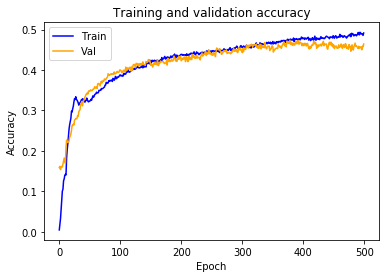

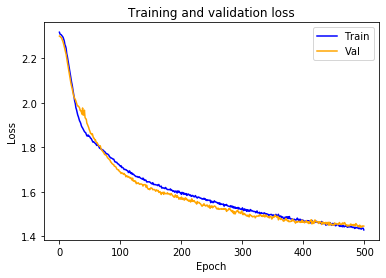

In [19]:
plot_history(history_spec)

In [20]:
print(f"Final validation accuracy is: {history_spec.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.464


In [22]:
file_path = git_root("models", "saved_models", "glcm_spec_angle0.h5")
net_spec.save(file_path)

## Mel map with angle 0

In [23]:
#We load the model
net_mel_0 = setup_model()

In [24]:
net_mel_0.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_0 = net_mel_0.fit(
    train["mel_map"][0], 
    epochs=500, 
    validation_data=test["mel_map"][0]
)

Epoch 1/500
394/394 [==============================] - 3s 8ms/step - loss: 2.3114 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3062 - accuracy: 0.1700 - val_loss: 2.3014 - val_accuracy: 0.0950
Epoch 3/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3054 - accuracy: 0.0944 - val_loss: 2.3003 - val_accuracy: 0.1029
Epoch 4/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3044 - accuracy: 0.0706 - val_loss: 2.2983 - val_accuracy: 0.1171
Epoch 5/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3026 - accuracy: 0.0662 - val_loss: 2.2949 - val_accuracy: 0.1300
Epoch 6/500
394/394 [==============================] - 2s 4ms/step - loss: 2.2983 - accuracy: 0.1045 - val_loss: 2.2889 - val_accuracy: 0.1593
Epoch 7/500
394/394 [==============================] - 1s 4ms/step - loss: 2.2903 - accuracy: 0.1767 - val_loss: 2.2790 - val_accuracy

Epoch 58/500
394/394 [==============================] - 1s 4ms/step - loss: 1.7937 - accuracy: 0.3398 - val_loss: 1.7788 - val_accuracy: 0.3729
Epoch 59/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7897 - accuracy: 0.3415 - val_loss: 1.7742 - val_accuracy: 0.3729
Epoch 60/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7849 - accuracy: 0.3427 - val_loss: 1.7695 - val_accuracy: 0.3743
Epoch 61/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7799 - accuracy: 0.3424 - val_loss: 1.7666 - val_accuracy: 0.3750
Epoch 62/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7759 - accuracy: 0.3430 - val_loss: 1.7627 - val_accuracy: 0.3800
Epoch 63/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7714 - accuracy: 0.3434 - val_loss: 1.7584 - val_accuracy: 0.3779
Epoch 64/500
394/394 [==============================] - 1s 4ms/step - loss: 1.7673 - accuracy: 0.3454 - val_loss: 1.7545 - val_accuracy:

Epoch 115/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6476 - accuracy: 0.4082 - val_loss: 1.6551 - val_accuracy: 0.4193
Epoch 116/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6466 - accuracy: 0.4087 - val_loss: 1.6539 - val_accuracy: 0.4207
Epoch 117/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6445 - accuracy: 0.4079 - val_loss: 1.6534 - val_accuracy: 0.4207
Epoch 118/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6433 - accuracy: 0.4098 - val_loss: 1.6533 - val_accuracy: 0.4193
Epoch 119/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6423 - accuracy: 0.4099 - val_loss: 1.6493 - val_accuracy: 0.4193
Epoch 120/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6416 - accuracy: 0.4117 - val_loss: 1.6485 - val_accuracy: 0.4193
Epoch 121/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6402 - accuracy: 0.4110 - val_loss: 1.6488 - val_ac

394/394 [==============================] - 1s 3ms/step - loss: 1.5973 - accuracy: 0.4244 - val_loss: 1.6259 - val_accuracy: 0.4214
Epoch 172/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5965 - accuracy: 0.4253 - val_loss: 1.6256 - val_accuracy: 0.4229
Epoch 173/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5951 - accuracy: 0.4224 - val_loss: 1.6239 - val_accuracy: 0.4229
Epoch 174/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5945 - accuracy: 0.4250 - val_loss: 1.6252 - val_accuracy: 0.4236
Epoch 175/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5943 - accuracy: 0.4247 - val_loss: 1.6226 - val_accuracy: 0.4243
Epoch 176/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5936 - accuracy: 0.4244 - val_loss: 1.6216 - val_accuracy: 0.4221
Epoch 177/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5928 - accuracy: 0.4239 - val_loss: 1.6222 - val_accuracy: 0.4214

394/394 [==============================] - 1s 3ms/step - loss: 1.5636 - accuracy: 0.4201 - val_loss: 1.6028 - val_accuracy: 0.4264
Epoch 228/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5635 - accuracy: 0.4206 - val_loss: 1.6035 - val_accuracy: 0.4271
Epoch 229/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5627 - accuracy: 0.4194 - val_loss: 1.6022 - val_accuracy: 0.4271
Epoch 230/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5624 - accuracy: 0.4203 - val_loss: 1.6008 - val_accuracy: 0.4271
Epoch 231/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5620 - accuracy: 0.4193 - val_loss: 1.6000 - val_accuracy: 0.4257
Epoch 232/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5617 - accuracy: 0.4187 - val_loss: 1.6002 - val_accuracy: 0.4264
Epoch 233/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5609 - accuracy: 0.4199 - val_loss: 1.5995 - val_accuracy: 0.4264

394/394 [==============================] - 1s 3ms/step - loss: 1.5365 - accuracy: 0.4225 - val_loss: 1.5716 - val_accuracy: 0.4229
Epoch 284/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5354 - accuracy: 0.4225 - val_loss: 1.5711 - val_accuracy: 0.4243
Epoch 285/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5362 - accuracy: 0.4221 - val_loss: 1.5702 - val_accuracy: 0.4264
Epoch 286/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5342 - accuracy: 0.4248 - val_loss: 1.5708 - val_accuracy: 0.4279
Epoch 287/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5344 - accuracy: 0.4252 - val_loss: 1.5719 - val_accuracy: 0.4279
Epoch 288/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5341 - accuracy: 0.4251 - val_loss: 1.5678 - val_accuracy: 0.4286
Epoch 289/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5333 - accuracy: 0.4250 - val_loss: 1.5697 - val_accuracy: 0.4286

394/394 [==============================] - 1s 3ms/step - loss: 1.5080 - accuracy: 0.4386 - val_loss: 1.5428 - val_accuracy: 0.4386
Epoch 340/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5076 - accuracy: 0.4390 - val_loss: 1.5422 - val_accuracy: 0.4379
Epoch 341/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5076 - accuracy: 0.4386 - val_loss: 1.5404 - val_accuracy: 0.4400
Epoch 342/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5071 - accuracy: 0.4388 - val_loss: 1.5417 - val_accuracy: 0.4400
Epoch 343/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5063 - accuracy: 0.4398 - val_loss: 1.5413 - val_accuracy: 0.4400
Epoch 344/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5056 - accuracy: 0.4389 - val_loss: 1.5406 - val_accuracy: 0.4379
Epoch 345/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5049 - accuracy: 0.4396 - val_loss: 1.5422 - val_accuracy: 0.4379

394/394 [==============================] - 1s 3ms/step - loss: 1.4859 - accuracy: 0.4515 - val_loss: 1.5291 - val_accuracy: 0.4386
Epoch 396/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4863 - accuracy: 0.4508 - val_loss: 1.5272 - val_accuracy: 0.4379
Epoch 397/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4854 - accuracy: 0.4521 - val_loss: 1.5277 - val_accuracy: 0.4364
Epoch 398/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4849 - accuracy: 0.4512 - val_loss: 1.5281 - val_accuracy: 0.4393
Epoch 399/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4845 - accuracy: 0.4510 - val_loss: 1.5269 - val_accuracy: 0.4386
Epoch 400/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4846 - accuracy: 0.4528 - val_loss: 1.5260 - val_accuracy: 0.4371
Epoch 401/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4831 - accuracy: 0.4530 - val_loss: 1.5259 - val_accuracy: 0.4386

394/394 [==============================] - 1s 3ms/step - loss: 1.4671 - accuracy: 0.4591 - val_loss: 1.5224 - val_accuracy: 0.4336
Epoch 452/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4667 - accuracy: 0.4598 - val_loss: 1.5216 - val_accuracy: 0.4336
Epoch 453/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4662 - accuracy: 0.4601 - val_loss: 1.5234 - val_accuracy: 0.4329
Epoch 454/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4659 - accuracy: 0.4592 - val_loss: 1.5224 - val_accuracy: 0.4336
Epoch 455/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4654 - accuracy: 0.4591 - val_loss: 1.5221 - val_accuracy: 0.4350
Epoch 456/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4656 - accuracy: 0.4606 - val_loss: 1.5234 - val_accuracy: 0.4336
Epoch 457/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4650 - accuracy: 0.4602 - val_loss: 1.5241 - val_accuracy: 0.4329

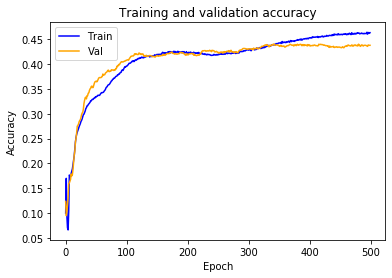

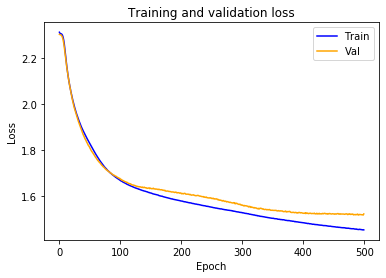

In [26]:
plot_history(history_mel_0)

In [27]:
print(f"Final validation accuracy is: {history_mel_0.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.438


In [28]:
file_path = git_root("models", "saved_models", "glcm_mel_angle0.h5")
net_mel_0.save(file_path)

## Mel map with angle 45

In [29]:
#We load the model
net_mel_45 = setup_model()

In [30]:
net_mel_45.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_45 = net_mel_45.fit(
    train["mel_map"][45], 
    epochs=500, 
    validation_data=test["mel_map"][45]
)

Epoch 1/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3136 - accuracy: 0.0915 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3096 - accuracy: 0.0507 - val_loss: 2.2973 - val_accuracy: 0.2143
Epoch 3/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3058 - accuracy: 0.0647 - val_loss: 2.2953 - val_accuracy: 0.1771
Epoch 4/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3032 - accuracy: 0.0524 - val_loss: 2.2921 - val_accuracy: 0.1700
Epoch 5/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3002 - accuracy: 0.0360 - val_loss: 2.2872 - val_accuracy: 0.1814
Epoch 6/500
394/394 [==============================] - 1s 4ms/step - loss: 2.2958 - accuracy: 0.0440 - val_loss: 2.2794 - val_accuracy: 0.1700
Epoch 7/500
394/394 [==============================] - 1s 4ms/step - loss: 2.2876 - accuracy: 0.0737 - val_loss: 2.2673 - val_accuracy

Epoch 58/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8426 - accuracy: 0.3256 - val_loss: 1.8217 - val_accuracy: 0.3486
Epoch 59/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8399 - accuracy: 0.3271 - val_loss: 1.8195 - val_accuracy: 0.3486
Epoch 60/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8368 - accuracy: 0.3303 - val_loss: 1.8169 - val_accuracy: 0.3493
Epoch 61/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8346 - accuracy: 0.3306 - val_loss: 1.8143 - val_accuracy: 0.3479
Epoch 62/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8315 - accuracy: 0.3325 - val_loss: 1.8105 - val_accuracy: 0.3464
Epoch 63/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8293 - accuracy: 0.3332 - val_loss: 1.8083 - val_accuracy: 0.3471
Epoch 64/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8271 - accuracy: 0.3347 - val_loss: 1.8074 - val_accuracy:

Epoch 115/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7316 - accuracy: 0.3571 - val_loss: 1.7242 - val_accuracy: 0.3664
Epoch 116/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7302 - accuracy: 0.3547 - val_loss: 1.7233 - val_accuracy: 0.3707
Epoch 117/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7289 - accuracy: 0.3566 - val_loss: 1.7223 - val_accuracy: 0.3721
Epoch 118/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7276 - accuracy: 0.3583 - val_loss: 1.7212 - val_accuracy: 0.3721
Epoch 119/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7253 - accuracy: 0.3587 - val_loss: 1.7215 - val_accuracy: 0.3750
Epoch 120/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7245 - accuracy: 0.3584 - val_loss: 1.7199 - val_accuracy: 0.3750
Epoch 121/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7231 - accuracy: 0.3574 - val_loss: 1.7162 - val_ac

394/394 [==============================] - 2s 4ms/step - loss: 1.6728 - accuracy: 0.3867 - val_loss: 1.6770 - val_accuracy: 0.3900
Epoch 172/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6718 - accuracy: 0.3873 - val_loss: 1.6777 - val_accuracy: 0.3914
Epoch 173/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6717 - accuracy: 0.3879 - val_loss: 1.6769 - val_accuracy: 0.3921
Epoch 174/500
394/394 [==============================] - 2s 4ms/step - loss: 1.6705 - accuracy: 0.3886 - val_loss: 1.6752 - val_accuracy: 0.3921
Epoch 175/500
394/394 [==============================] - 2s 4ms/step - loss: 1.6692 - accuracy: 0.3888 - val_loss: 1.6752 - val_accuracy: 0.3943
Epoch 176/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6686 - accuracy: 0.3888 - val_loss: 1.6736 - val_accuracy: 0.3936
Epoch 177/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6679 - accuracy: 0.3898 - val_loss: 1.6741 - val_accuracy: 0.3950

394/394 [==============================] - 1s 4ms/step - loss: 1.6322 - accuracy: 0.3951 - val_loss: 1.6570 - val_accuracy: 0.4086
Epoch 228/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6314 - accuracy: 0.3959 - val_loss: 1.6555 - val_accuracy: 0.4079
Epoch 229/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6313 - accuracy: 0.3973 - val_loss: 1.6563 - val_accuracy: 0.4064
Epoch 230/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6308 - accuracy: 0.3964 - val_loss: 1.6536 - val_accuracy: 0.4079
Epoch 231/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6299 - accuracy: 0.3969 - val_loss: 1.6546 - val_accuracy: 0.4079
Epoch 232/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6287 - accuracy: 0.3961 - val_loss: 1.6554 - val_accuracy: 0.4093
Epoch 233/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6286 - accuracy: 0.3959 - val_loss: 1.6552 - val_accuracy: 0.4079

394/394 [==============================] - 1s 3ms/step - loss: 1.6004 - accuracy: 0.4131 - val_loss: 1.6416 - val_accuracy: 0.4079
Epoch 284/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6002 - accuracy: 0.4127 - val_loss: 1.6416 - val_accuracy: 0.4071
Epoch 285/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5993 - accuracy: 0.4133 - val_loss: 1.6422 - val_accuracy: 0.4071
Epoch 286/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5987 - accuracy: 0.4137 - val_loss: 1.6417 - val_accuracy: 0.4064
Epoch 287/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5981 - accuracy: 0.4137 - val_loss: 1.6411 - val_accuracy: 0.4064
Epoch 288/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5986 - accuracy: 0.4143 - val_loss: 1.6420 - val_accuracy: 0.4071
Epoch 289/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5977 - accuracy: 0.4145 - val_loss: 1.6406 - val_accuracy: 0.4064

394/394 [==============================] - 1s 3ms/step - loss: 1.5760 - accuracy: 0.4194 - val_loss: 1.6359 - val_accuracy: 0.4057
Epoch 340/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5754 - accuracy: 0.4209 - val_loss: 1.6339 - val_accuracy: 0.4057
Epoch 341/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5756 - accuracy: 0.4194 - val_loss: 1.6335 - val_accuracy: 0.4057
Epoch 342/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5748 - accuracy: 0.4199 - val_loss: 1.6345 - val_accuracy: 0.4057
Epoch 343/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5736 - accuracy: 0.4221 - val_loss: 1.6332 - val_accuracy: 0.4071
Epoch 344/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5740 - accuracy: 0.4186 - val_loss: 1.6314 - val_accuracy: 0.4064
Epoch 345/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5736 - accuracy: 0.4208 - val_loss: 1.6337 - val_accuracy: 0.4057

394/394 [==============================] - 1s 3ms/step - loss: 1.5553 - accuracy: 0.4263 - val_loss: 1.6282 - val_accuracy: 0.4050
Epoch 396/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5541 - accuracy: 0.4278 - val_loss: 1.6290 - val_accuracy: 0.4050
Epoch 397/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5543 - accuracy: 0.4270 - val_loss: 1.6305 - val_accuracy: 0.4036
Epoch 398/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5540 - accuracy: 0.4280 - val_loss: 1.6293 - val_accuracy: 0.4057
Epoch 399/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5534 - accuracy: 0.4279 - val_loss: 1.6299 - val_accuracy: 0.4050
Epoch 400/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5538 - accuracy: 0.4279 - val_loss: 1.6281 - val_accuracy: 0.4050
Epoch 401/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5530 - accuracy: 0.4263 - val_loss: 1.6284 - val_accuracy: 0.4050

394/394 [==============================] - 1s 3ms/step - loss: 1.5378 - accuracy: 0.4304 - val_loss: 1.6320 - val_accuracy: 0.4007
Epoch 452/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5381 - accuracy: 0.4298 - val_loss: 1.6315 - val_accuracy: 0.4007
Epoch 453/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5372 - accuracy: 0.4295 - val_loss: 1.6315 - val_accuracy: 0.4007
Epoch 454/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5376 - accuracy: 0.4299 - val_loss: 1.6316 - val_accuracy: 0.4000
Epoch 455/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5368 - accuracy: 0.4294 - val_loss: 1.6286 - val_accuracy: 0.4007
Epoch 456/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5370 - accuracy: 0.4310 - val_loss: 1.6316 - val_accuracy: 0.4007
Epoch 457/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5363 - accuracy: 0.4301 - val_loss: 1.6296 - val_accuracy: 0.4007

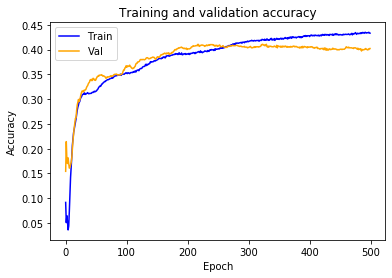

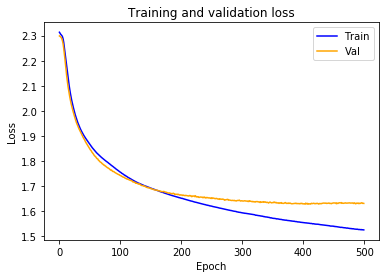

In [32]:
plot_history(history_mel_45)

In [33]:
print(f"Final validation accuracy is: {history_mel_45.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.402


In [34]:
file_path = git_root("models", "saved_models", "glcm_mel_angle45.h5")
net_mel_45.save(file_path)

## Mel map with angle 90

In [35]:
#We load the model
net_mel_90 = setup_model()

In [36]:
net_mel_90.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_90 = net_mel_90.fit(
    train["mel_map"][90], 
    epochs=500, 
    validation_data=test["mel_map"][90]
)

Epoch 1/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3093 - accuracy: 0.1092 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3080 - accuracy: 0.1000 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3097 - accuracy: 0.0502 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3076 - accuracy: 0.0773 - val_loss: 2.3030 - val_accuracy: 0.0836
Epoch 5/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3071 - accuracy: 0.0791 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 6/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3078 - accuracy: 0.1000 - val_loss: 2.3029 - val_accuracy: 0.1036
Epoch 7/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3080 - accuracy: 0.0435 - val_loss: 2.3026 - val_accuracy

Epoch 58/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2353 - accuracy: 0.1878 - val_loss: 2.2393 - val_accuracy: 0.1786
Epoch 59/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2224 - accuracy: 0.1940 - val_loss: 2.2292 - val_accuracy: 0.1750
Epoch 60/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2107 - accuracy: 0.1940 - val_loss: 2.2186 - val_accuracy: 0.1814
Epoch 61/500
394/394 [==============================] - 1s 3ms/step - loss: 2.1994 - accuracy: 0.1913 - val_loss: 2.2072 - val_accuracy: 0.1950
Epoch 62/500
394/394 [==============================] - 1s 3ms/step - loss: 2.1893 - accuracy: 0.1939 - val_loss: 2.1956 - val_accuracy: 0.2100
Epoch 63/500
394/394 [==============================] - 1s 3ms/step - loss: 2.1783 - accuracy: 0.1985 - val_loss: 2.1852 - val_accuracy: 0.2143
Epoch 64/500
394/394 [==============================] - 1s 3ms/step - loss: 2.1688 - accuracy: 0.2006 - val_loss: 2.1754 - val_accuracy:

Epoch 115/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9199 - accuracy: 0.2990 - val_loss: 1.9362 - val_accuracy: 0.3150
Epoch 116/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9167 - accuracy: 0.3010 - val_loss: 1.9317 - val_accuracy: 0.3143
Epoch 117/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9141 - accuracy: 0.3018 - val_loss: 1.9304 - val_accuracy: 0.3164
Epoch 118/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9108 - accuracy: 0.3040 - val_loss: 1.9274 - val_accuracy: 0.3164
Epoch 119/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9093 - accuracy: 0.3044 - val_loss: 1.9253 - val_accuracy: 0.3186
Epoch 120/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9065 - accuracy: 0.3073 - val_loss: 1.9223 - val_accuracy: 0.3193
Epoch 121/500
394/394 [==============================] - 1s 3ms/step - loss: 1.9038 - accuracy: 0.3086 - val_loss: 1.9209 - val_ac

394/394 [==============================] - 1s 3ms/step - loss: 1.8188 - accuracy: 0.3297 - val_loss: 1.8689 - val_accuracy: 0.3036
Epoch 172/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8180 - accuracy: 0.3305 - val_loss: 1.8692 - val_accuracy: 0.3036
Epoch 173/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8161 - accuracy: 0.3307 - val_loss: 1.8692 - val_accuracy: 0.3007
Epoch 174/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8149 - accuracy: 0.3302 - val_loss: 1.8678 - val_accuracy: 0.3000
Epoch 175/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8146 - accuracy: 0.3313 - val_loss: 1.8670 - val_accuracy: 0.2993
Epoch 176/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8129 - accuracy: 0.3333 - val_loss: 1.8691 - val_accuracy: 0.2993
Epoch 177/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8112 - accuracy: 0.3338 - val_loss: 1.8679 - val_accuracy: 0.3029

394/394 [==============================] - 1s 3ms/step - loss: 1.7581 - accuracy: 0.3544 - val_loss: 1.8418 - val_accuracy: 0.3093
Epoch 228/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7570 - accuracy: 0.3556 - val_loss: 1.8417 - val_accuracy: 0.3107
Epoch 229/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7563 - accuracy: 0.3556 - val_loss: 1.8408 - val_accuracy: 0.3107
Epoch 230/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7552 - accuracy: 0.3572 - val_loss: 1.8382 - val_accuracy: 0.3121
Epoch 231/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7538 - accuracy: 0.3568 - val_loss: 1.8392 - val_accuracy: 0.3129
Epoch 232/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7530 - accuracy: 0.3571 - val_loss: 1.8376 - val_accuracy: 0.3143
Epoch 233/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7518 - accuracy: 0.3588 - val_loss: 1.8371 - val_accuracy: 0.3129

394/394 [==============================] - 1s 3ms/step - loss: 1.7090 - accuracy: 0.3776 - val_loss: 1.7976 - val_accuracy: 0.3471
Epoch 284/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7079 - accuracy: 0.3777 - val_loss: 1.7972 - val_accuracy: 0.3457
Epoch 285/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7075 - accuracy: 0.3796 - val_loss: 1.7967 - val_accuracy: 0.3457
Epoch 286/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7066 - accuracy: 0.3814 - val_loss: 1.7965 - val_accuracy: 0.3443
Epoch 287/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7057 - accuracy: 0.3816 - val_loss: 1.7952 - val_accuracy: 0.3450
Epoch 288/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7053 - accuracy: 0.3795 - val_loss: 1.7964 - val_accuracy: 0.3450
Epoch 289/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7044 - accuracy: 0.3806 - val_loss: 1.7928 - val_accuracy: 0.3479

394/394 [==============================] - 1s 3ms/step - loss: 1.6614 - accuracy: 0.3994 - val_loss: 1.7551 - val_accuracy: 0.3636
Epoch 340/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6606 - accuracy: 0.4006 - val_loss: 1.7536 - val_accuracy: 0.3629
Epoch 341/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6595 - accuracy: 0.4002 - val_loss: 1.7544 - val_accuracy: 0.3636
Epoch 342/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6578 - accuracy: 0.3992 - val_loss: 1.7545 - val_accuracy: 0.3636
Epoch 343/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6568 - accuracy: 0.3980 - val_loss: 1.7538 - val_accuracy: 0.3650
Epoch 344/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6568 - accuracy: 0.3991 - val_loss: 1.7525 - val_accuracy: 0.3671
Epoch 345/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6563 - accuracy: 0.3999 - val_loss: 1.7515 - val_accuracy: 0.3686

394/394 [==============================] - 1s 4ms/step - loss: 1.6229 - accuracy: 0.4113 - val_loss: 1.7367 - val_accuracy: 0.3679
Epoch 396/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6214 - accuracy: 0.4126 - val_loss: 1.7372 - val_accuracy: 0.3686
Epoch 397/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6218 - accuracy: 0.4113 - val_loss: 1.7384 - val_accuracy: 0.3693
Epoch 398/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6213 - accuracy: 0.4117 - val_loss: 1.7381 - val_accuracy: 0.3664
Epoch 399/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6204 - accuracy: 0.4110 - val_loss: 1.7364 - val_accuracy: 0.3686
Epoch 400/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6190 - accuracy: 0.4115 - val_loss: 1.7361 - val_accuracy: 0.3679
Epoch 401/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6183 - accuracy: 0.4137 - val_loss: 1.7375 - val_accuracy: 0.3693

394/394 [==============================] - 1s 3ms/step - loss: 1.5960 - accuracy: 0.4209 - val_loss: 1.7193 - val_accuracy: 0.3721
Epoch 452/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5964 - accuracy: 0.4198 - val_loss: 1.7183 - val_accuracy: 0.3721
Epoch 453/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5948 - accuracy: 0.4190 - val_loss: 1.7186 - val_accuracy: 0.3721
Epoch 454/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5941 - accuracy: 0.4194 - val_loss: 1.7186 - val_accuracy: 0.3714
Epoch 455/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5937 - accuracy: 0.4189 - val_loss: 1.7169 - val_accuracy: 0.3721
Epoch 456/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5954 - accuracy: 0.4194 - val_loss: 1.7188 - val_accuracy: 0.3729
Epoch 457/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5935 - accuracy: 0.4208 - val_loss: 1.7161 - val_accuracy: 0.3721

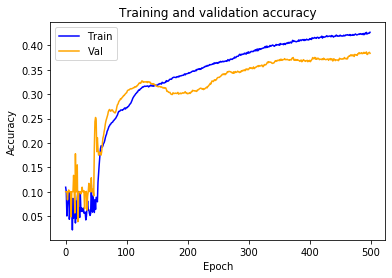

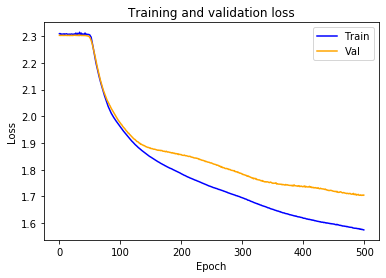

In [38]:
plot_history(history_mel_90)

In [39]:
print(f"Final validation accuracy is: {history_mel_90.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.384


In [40]:
file_path = git_root("models", "saved_models", "glcm_mel_angle90.h5")
net_mel_90.save(file_path)

## Mel map with angle 135

In [41]:
#We load the model
net_mel_135 = setup_model()

In [42]:
net_mel_135.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_135 = net_mel_135.fit(
    train["mel_map"][135], 
    epochs=500, 
    validation_data=test["mel_map"][135]
)

Epoch 1/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3115 - accuracy: 0.0999 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3037 - accuracy: 0.0923 - val_loss: 2.2889 - val_accuracy: 0.1307
Epoch 3/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2974 - accuracy: 0.1258 - val_loss: 2.2805 - val_accuracy: 0.1493
Epoch 4/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2890 - accuracy: 0.1532 - val_loss: 2.2681 - val_accuracy: 0.1643
Epoch 5/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2774 - accuracy: 0.1694 - val_loss: 2.2514 - val_accuracy: 0.1714
Epoch 6/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2625 - accuracy: 0.1677 - val_loss: 2.2319 - val_accuracy: 0.1736
Epoch 7/500
394/394 [==============================] - 1s 3ms/step - loss: 2.2446 - accuracy: 0.1713 - val_loss: 2.2106 - val_accuracy

Epoch 58/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8366 - accuracy: 0.3393 - val_loss: 1.8460 - val_accuracy: 0.3136
Epoch 59/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8341 - accuracy: 0.3417 - val_loss: 1.8434 - val_accuracy: 0.3157
Epoch 60/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8306 - accuracy: 0.3431 - val_loss: 1.8409 - val_accuracy: 0.3164
Epoch 61/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8277 - accuracy: 0.3433 - val_loss: 1.8387 - val_accuracy: 0.3164
Epoch 62/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8254 - accuracy: 0.3433 - val_loss: 1.8366 - val_accuracy: 0.3171
Epoch 63/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8227 - accuracy: 0.3456 - val_loss: 1.8341 - val_accuracy: 0.3164
Epoch 64/500
394/394 [==============================] - 1s 3ms/step - loss: 1.8202 - accuracy: 0.3457 - val_loss: 1.8326 - val_accuracy:

Epoch 115/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7225 - accuracy: 0.3820 - val_loss: 1.7505 - val_accuracy: 0.3564
Epoch 116/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7213 - accuracy: 0.3844 - val_loss: 1.7490 - val_accuracy: 0.3564
Epoch 117/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7200 - accuracy: 0.3837 - val_loss: 1.7472 - val_accuracy: 0.3571
Epoch 118/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7182 - accuracy: 0.3847 - val_loss: 1.7473 - val_accuracy: 0.3586
Epoch 119/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7174 - accuracy: 0.3845 - val_loss: 1.7461 - val_accuracy: 0.3586
Epoch 120/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7160 - accuracy: 0.3852 - val_loss: 1.7448 - val_accuracy: 0.3564
Epoch 121/500
394/394 [==============================] - 1s 3ms/step - loss: 1.7142 - accuracy: 0.3839 - val_loss: 1.7446 - val_ac

394/394 [==============================] - 1s 3ms/step - loss: 1.6574 - accuracy: 0.3952 - val_loss: 1.7045 - val_accuracy: 0.3700
Epoch 172/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6566 - accuracy: 0.3960 - val_loss: 1.7053 - val_accuracy: 0.3700
Epoch 173/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6545 - accuracy: 0.3975 - val_loss: 1.7038 - val_accuracy: 0.3693
Epoch 174/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6544 - accuracy: 0.3945 - val_loss: 1.7036 - val_accuracy: 0.3686
Epoch 175/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6533 - accuracy: 0.3983 - val_loss: 1.7016 - val_accuracy: 0.3671
Epoch 176/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6524 - accuracy: 0.3977 - val_loss: 1.7034 - val_accuracy: 0.3686
Epoch 177/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6514 - accuracy: 0.3996 - val_loss: 1.7018 - val_accuracy: 0.3679

394/394 [==============================] - 1s 3ms/step - loss: 1.6064 - accuracy: 0.4064 - val_loss: 1.6750 - val_accuracy: 0.3821
Epoch 228/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6055 - accuracy: 0.4056 - val_loss: 1.6751 - val_accuracy: 0.3829
Epoch 229/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6051 - accuracy: 0.4073 - val_loss: 1.6737 - val_accuracy: 0.3821
Epoch 230/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6039 - accuracy: 0.4044 - val_loss: 1.6723 - val_accuracy: 0.3836
Epoch 231/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6037 - accuracy: 0.4054 - val_loss: 1.6719 - val_accuracy: 0.3857
Epoch 232/500
394/394 [==============================] - 1s 3ms/step - loss: 1.6013 - accuracy: 0.4072 - val_loss: 1.6722 - val_accuracy: 0.3850
Epoch 233/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6015 - accuracy: 0.4067 - val_loss: 1.6712 - val_accuracy: 0.3857

394/394 [==============================] - 1s 3ms/step - loss: 1.5655 - accuracy: 0.4126 - val_loss: 1.6603 - val_accuracy: 0.3829
Epoch 284/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5648 - accuracy: 0.4133 - val_loss: 1.6599 - val_accuracy: 0.3857
Epoch 285/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5647 - accuracy: 0.4133 - val_loss: 1.6603 - val_accuracy: 0.3871
Epoch 286/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5628 - accuracy: 0.4130 - val_loss: 1.6602 - val_accuracy: 0.3871
Epoch 287/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5620 - accuracy: 0.4127 - val_loss: 1.6595 - val_accuracy: 0.3864
Epoch 288/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5616 - accuracy: 0.4136 - val_loss: 1.6610 - val_accuracy: 0.3850
Epoch 289/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5611 - accuracy: 0.4144 - val_loss: 1.6588 - val_accuracy: 0.3857

394/394 [==============================] - 1s 3ms/step - loss: 1.5347 - accuracy: 0.4229 - val_loss: 1.6434 - val_accuracy: 0.3907
Epoch 340/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5348 - accuracy: 0.4229 - val_loss: 1.6423 - val_accuracy: 0.3914
Epoch 341/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5329 - accuracy: 0.4225 - val_loss: 1.6413 - val_accuracy: 0.3900
Epoch 342/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5337 - accuracy: 0.4233 - val_loss: 1.6417 - val_accuracy: 0.3914
Epoch 343/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5319 - accuracy: 0.4228 - val_loss: 1.6419 - val_accuracy: 0.3907
Epoch 344/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5315 - accuracy: 0.4259 - val_loss: 1.6408 - val_accuracy: 0.3907
Epoch 345/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5311 - accuracy: 0.4249 - val_loss: 1.6422 - val_accuracy: 0.3893

394/394 [==============================] - 1s 3ms/step - loss: 1.5092 - accuracy: 0.4324 - val_loss: 1.6281 - val_accuracy: 0.3979
Epoch 396/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5088 - accuracy: 0.4331 - val_loss: 1.6270 - val_accuracy: 0.4014
Epoch 397/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5087 - accuracy: 0.4333 - val_loss: 1.6258 - val_accuracy: 0.4000
Epoch 398/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5089 - accuracy: 0.4325 - val_loss: 1.6261 - val_accuracy: 0.4021
Epoch 399/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5078 - accuracy: 0.4331 - val_loss: 1.6264 - val_accuracy: 0.4000
Epoch 400/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5080 - accuracy: 0.4334 - val_loss: 1.6267 - val_accuracy: 0.4000
Epoch 401/500
394/394 [==============================] - 1s 3ms/step - loss: 1.5073 - accuracy: 0.4352 - val_loss: 1.6260 - val_accuracy: 0.4029

394/394 [==============================] - 1s 3ms/step - loss: 1.4875 - accuracy: 0.4441 - val_loss: 1.6206 - val_accuracy: 0.4000
Epoch 452/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4871 - accuracy: 0.4425 - val_loss: 1.6205 - val_accuracy: 0.4000
Epoch 453/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4866 - accuracy: 0.4433 - val_loss: 1.6196 - val_accuracy: 0.4007
Epoch 454/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4871 - accuracy: 0.4437 - val_loss: 1.6200 - val_accuracy: 0.4000
Epoch 455/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4850 - accuracy: 0.4446 - val_loss: 1.6222 - val_accuracy: 0.3993
Epoch 456/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4854 - accuracy: 0.4440 - val_loss: 1.6205 - val_accuracy: 0.3986
Epoch 457/500
394/394 [==============================] - 1s 3ms/step - loss: 1.4851 - accuracy: 0.4444 - val_loss: 1.6213 - val_accuracy: 0.4000

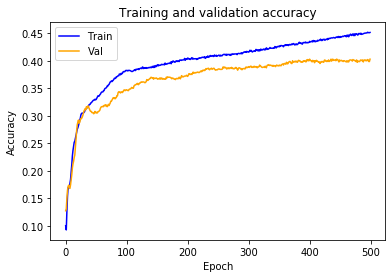

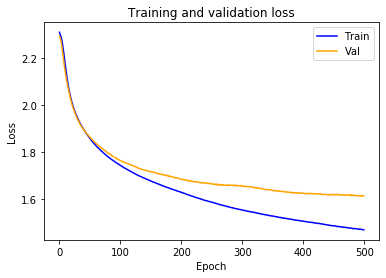

In [44]:
plot_history(history_mel_135)

In [45]:
print(f"Final validation accuracy is: {history_mel_135.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.403


In [46]:
file_path = git_root("models", "saved_models", "glcm_mel_angle135.h5")
net_mel_135.save(file_path)

# Stacked mel maps

In [47]:
#We load the model
net_mel_stacked = setup_model(M=4)
net_mel_stacked.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 10, 12)        1740      
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 5, 5, 12)          0         
_________________________________________________________________
affine (AffineScalar)        (None, 5, 5, 12)          2         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 3, 6)           654       
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
____________________________________________________

In [48]:
net_mel_stacked.compile(
    optimizer=Adam(learning_rate=0.0001, epsilon=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_stacked = net_mel_stacked.fit(
    stacked_train, 
    epochs=500, 
    validation_data=stacked_test
)

Epoch 1/500
394/394 [==============================] - 3s 7ms/step - loss: 2.3168 - accuracy: 0.0772 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3140 - accuracy: 0.0721 - val_loss: 2.2993 - val_accuracy: 0.1293
Epoch 3/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3090 - accuracy: 0.0683 - val_loss: 2.2980 - val_accuracy: 0.1264
Epoch 4/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3061 - accuracy: 0.0787 - val_loss: 2.2966 - val_accuracy: 0.1007
Epoch 5/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3040 - accuracy: 0.0883 - val_loss: 2.2945 - val_accuracy: 0.1000
Epoch 6/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3011 - accuracy: 0.1029 - val_loss: 2.2914 - val_accuracy: 0.1193
Epoch 7/500
394/394 [==============================] - 1s 4ms/step - loss: 2.2969 - accuracy: 0.1096 - val_loss: 2.2852 - val_accuracy

Epoch 58/500
394/394 [==============================] - 2s 4ms/step - loss: 1.9053 - accuracy: 0.2972 - val_loss: 1.9386 - val_accuracy: 0.3214
Epoch 59/500
394/394 [==============================] - 1s 4ms/step - loss: 1.9023 - accuracy: 0.2990 - val_loss: 1.9354 - val_accuracy: 0.3193
Epoch 60/500
394/394 [==============================] - 2s 4ms/step - loss: 1.8968 - accuracy: 0.2990 - val_loss: 1.9306 - val_accuracy: 0.3250
Epoch 61/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8938 - accuracy: 0.3001 - val_loss: 1.9257 - val_accuracy: 0.3286
Epoch 62/500
394/394 [==============================] - 2s 4ms/step - loss: 1.8901 - accuracy: 0.3038 - val_loss: 1.9212 - val_accuracy: 0.3314
Epoch 63/500
394/394 [==============================] - 1s 4ms/step - loss: 1.8868 - accuracy: 0.3042 - val_loss: 1.9163 - val_accuracy: 0.3350
Epoch 64/500
394/394 [==============================] - 2s 4ms/step - loss: 1.8836 - accuracy: 0.3063 - val_loss: 1.9103 - val_accuracy:

Epoch 115/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7421 - accuracy: 0.3498 - val_loss: 1.7674 - val_accuracy: 0.3379
Epoch 116/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7406 - accuracy: 0.3509 - val_loss: 1.7675 - val_accuracy: 0.3386
Epoch 117/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7377 - accuracy: 0.3519 - val_loss: 1.7651 - val_accuracy: 0.3364
Epoch 118/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7363 - accuracy: 0.3529 - val_loss: 1.7630 - val_accuracy: 0.3400
Epoch 119/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7344 - accuracy: 0.3531 - val_loss: 1.7648 - val_accuracy: 0.3414
Epoch 120/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7324 - accuracy: 0.3511 - val_loss: 1.7629 - val_accuracy: 0.3414
Epoch 121/500
394/394 [==============================] - 2s 5ms/step - loss: 1.7314 - accuracy: 0.3529 - val_loss: 1.7617 - val_ac

394/394 [==============================] - 1s 4ms/step - loss: 1.6590 - accuracy: 0.3914 - val_loss: 1.7031 - val_accuracy: 0.3557
Epoch 172/500
394/394 [==============================] - 2s 4ms/step - loss: 1.6566 - accuracy: 0.3929 - val_loss: 1.7038 - val_accuracy: 0.3514
Epoch 173/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6552 - accuracy: 0.3931 - val_loss: 1.7027 - val_accuracy: 0.3536
Epoch 174/500
394/394 [==============================] - 2s 4ms/step - loss: 1.6543 - accuracy: 0.3910 - val_loss: 1.7021 - val_accuracy: 0.3521
Epoch 175/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6534 - accuracy: 0.3918 - val_loss: 1.6999 - val_accuracy: 0.3593
Epoch 176/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6496 - accuracy: 0.3940 - val_loss: 1.7006 - val_accuracy: 0.3550
Epoch 177/500
394/394 [==============================] - 1s 4ms/step - loss: 1.6482 - accuracy: 0.3942 - val_loss: 1.6975 - val_accuracy: 0.3529

394/394 [==============================] - 1s 4ms/step - loss: 1.5917 - accuracy: 0.4147 - val_loss: 1.6523 - val_accuracy: 0.3729
Epoch 228/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5915 - accuracy: 0.4152 - val_loss: 1.6511 - val_accuracy: 0.3743
Epoch 229/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5900 - accuracy: 0.4167 - val_loss: 1.6517 - val_accuracy: 0.3779
Epoch 230/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5891 - accuracy: 0.4158 - val_loss: 1.6499 - val_accuracy: 0.3793
Epoch 231/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5870 - accuracy: 0.4179 - val_loss: 1.6505 - val_accuracy: 0.3757
Epoch 232/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5866 - accuracy: 0.4202 - val_loss: 1.6490 - val_accuracy: 0.3721
Epoch 233/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5848 - accuracy: 0.4171 - val_loss: 1.6458 - val_accuracy: 0.3764

394/394 [==============================] - 2s 4ms/step - loss: 1.5427 - accuracy: 0.4374 - val_loss: 1.6241 - val_accuracy: 0.3929
Epoch 284/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5430 - accuracy: 0.4396 - val_loss: 1.6225 - val_accuracy: 0.3950
Epoch 285/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5402 - accuracy: 0.4386 - val_loss: 1.6242 - val_accuracy: 0.3914
Epoch 286/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5435 - accuracy: 0.4356 - val_loss: 1.6217 - val_accuracy: 0.3936
Epoch 287/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5397 - accuracy: 0.4392 - val_loss: 1.6224 - val_accuracy: 0.3936
Epoch 288/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5390 - accuracy: 0.4399 - val_loss: 1.6209 - val_accuracy: 0.3943
Epoch 289/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5393 - accuracy: 0.4385 - val_loss: 1.6225 - val_accuracy: 0.3950

394/394 [==============================] - 1s 4ms/step - loss: 1.5075 - accuracy: 0.4464 - val_loss: 1.6117 - val_accuracy: 0.3950
Epoch 340/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5041 - accuracy: 0.4485 - val_loss: 1.6142 - val_accuracy: 0.3943
Epoch 341/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5049 - accuracy: 0.4448 - val_loss: 1.6124 - val_accuracy: 0.3971
Epoch 342/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5037 - accuracy: 0.4455 - val_loss: 1.6153 - val_accuracy: 0.3964
Epoch 343/500
394/394 [==============================] - 2s 4ms/step - loss: 1.5038 - accuracy: 0.4473 - val_loss: 1.6139 - val_accuracy: 0.3957
Epoch 344/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5032 - accuracy: 0.4464 - val_loss: 1.6141 - val_accuracy: 0.3957
Epoch 345/500
394/394 [==============================] - 1s 4ms/step - loss: 1.5040 - accuracy: 0.4443 - val_loss: 1.6141 - val_accuracy: 0.3993

394/394 [==============================] - 2s 4ms/step - loss: 1.4736 - accuracy: 0.4584 - val_loss: 1.6150 - val_accuracy: 0.4064
Epoch 396/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4746 - accuracy: 0.4588 - val_loss: 1.6118 - val_accuracy: 0.4050
Epoch 397/500
394/394 [==============================] - 2s 4ms/step - loss: 1.4749 - accuracy: 0.4571 - val_loss: 1.6111 - val_accuracy: 0.4036
Epoch 398/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4744 - accuracy: 0.4560 - val_loss: 1.6134 - val_accuracy: 0.4000
Epoch 399/500
394/394 [==============================] - 2s 4ms/step - loss: 1.4733 - accuracy: 0.4582 - val_loss: 1.6124 - val_accuracy: 0.4071
Epoch 400/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4733 - accuracy: 0.4587 - val_loss: 1.6121 - val_accuracy: 0.4014
Epoch 401/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4733 - accuracy: 0.4567 - val_loss: 1.6127 - val_accuracy: 0.4064

394/394 [==============================] - 1s 4ms/step - loss: 1.4501 - accuracy: 0.4733 - val_loss: 1.5823 - val_accuracy: 0.3914
Epoch 452/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4505 - accuracy: 0.4709 - val_loss: 1.5813 - val_accuracy: 0.3943
Epoch 453/500
394/394 [==============================] - 2s 4ms/step - loss: 1.4525 - accuracy: 0.4720 - val_loss: 1.5782 - val_accuracy: 0.3979
Epoch 454/500
394/394 [==============================] - 2s 4ms/step - loss: 1.4504 - accuracy: 0.4734 - val_loss: 1.5762 - val_accuracy: 0.3979
Epoch 455/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4488 - accuracy: 0.4739 - val_loss: 1.5782 - val_accuracy: 0.3993
Epoch 456/500
394/394 [==============================] - 2s 4ms/step - loss: 1.4494 - accuracy: 0.4733 - val_loss: 1.5793 - val_accuracy: 0.3950
Epoch 457/500
394/394 [==============================] - 1s 4ms/step - loss: 1.4499 - accuracy: 0.4721 - val_loss: 1.5783 - val_accuracy: 0.3979

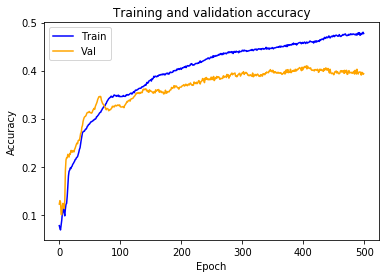

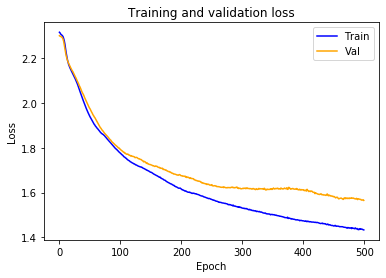

In [50]:
plot_history(history_mel_stacked)

In [51]:
print(f"Final validation accuracy is: {history_mel_stacked.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.394


In [52]:
file_path = git_root("models", "saved_models", "glcm_mel_stacked.h5")
net_mel_stacked.save(file_path)

## Combined loss curves

In [53]:
val_losses = pd.DataFrame(
    {
        "s-GLCM(a)": history_spec.history["val_loss"],
        "GLCM(a)": history_mel_0.history["val_loss"],
        "GLCM(b)": history_mel_45.history["val_loss"],
        "GLCM(c)": history_mel_90.history["val_loss"],
        "GLCM(d)": history_mel_135.history["val_loss"],
        "i-GLCM": history_mel_stacked.history["val_loss"]
    }
).melt()

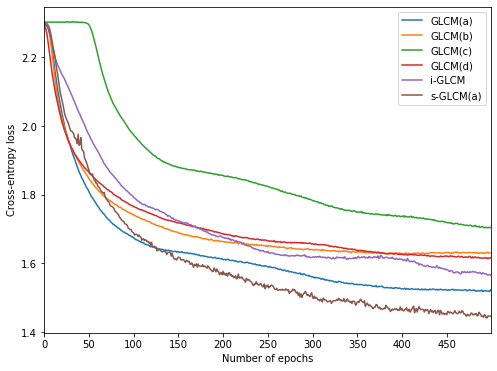

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
for label, df in val_losses.groupby("variable"):
    df["value"].reset_index(drop=True).plot(ax=ax, label=label)
plt.ylabel("Cross-entropy loss")
plt.xlabel("Number of epochs")
plt.xticks(range(0, 500, 50))
plt.legend()

In [56]:
fig.savefig(git_root("training", "loss_curves.png"))